In [1]:
import skimage
import numpy as np
from collections import defaultdict, Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from skimage import io
from skimage import transform, feature
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
import os.path
import time 

In [4]:
from pyimage.pipeline import ImagePipeline
from numpy.linalg import svd

# Basic read/transform

In [107]:
os.listdir('image_test') 

['.DS_Store',
 'dining_chair',
 'dining_table',
 'futon_ANDO1714_3.jpg',
 'futon_BYSN1003_1.jpg',
 'futon_BYSN1032_0.jpg',
 'nightstand_ACBP1054_0.jpg',
 'nightstand_ANDO1522_1.jpg',
 'nightstand_ATF1862_1.jpg',
 'nightstand_ATF1863_0.jpg']

In [299]:
ns = skimage.io.imread('image_test/nightstand_ANDO1522_1.jpg')
ns.shape

(400, 400, 3)

In [300]:
ft = skimage.io.imread('image_test/futon_BYSN1003_1.jpg')
ft.shape

(400, 400, 3)

In [301]:
dc = skimage.io.imread('image_test/dining_chair/dining_chair_AAM1013_0.jpg')

In [302]:
print ns[0][0]
print ft[0][0]

[255 255 255]
[255 255 255]


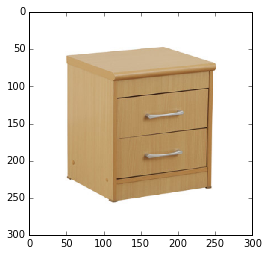

In [303]:
ns_s = transform.resize(ns, (300,300,3))
skimage.io.imshow(ns_s)

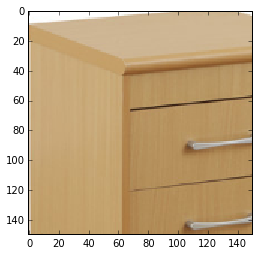

In [304]:
ns_room =  ns_s[50:200,50:200]
skimage.io.imshow(ns_room)

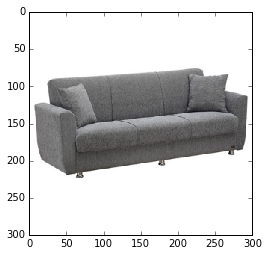

In [305]:
ft_s = transform.resize(ft, (300,300,3))
skimage.io.imshow(ft_s)

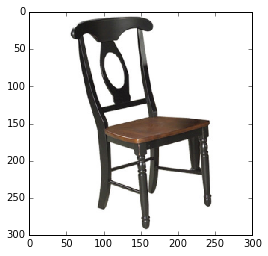

In [306]:
dc_s = transform.resize(dc, (300,300,3))
skimage.io.imshow(dc_s)

In [307]:
print ns_s[0][0]
print ft_s[0][0]

[ 1.  1.  1.]
[ 1.  1.  1.]


In [308]:
ns_gray = skimage.color.rgb2gray(ns_s)
ft_gray = skimage.color.rgb2gray(ft_s)
dc_gray = skimage.color.rgb2gray(dc_s)

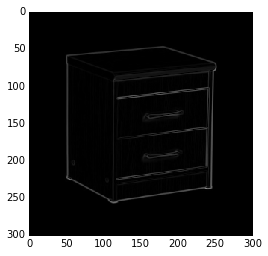

In [64]:
ns_sobal = skimage.filters.sobel(ns_gray)
skimage.io.imshow(ns_sobal)

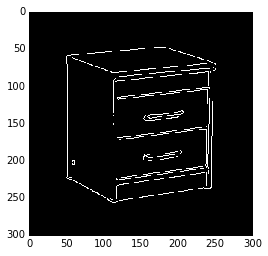

In [65]:
ns_canny = feature.canny(ns_gray, sigma=1)
skimage.io.imshow(ns_canny)

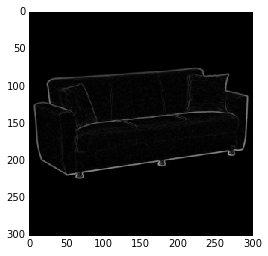

In [66]:
ft_sobal = skimage.filters.sobel(ft_gray)
skimage.io.imshow(ft_sobal)

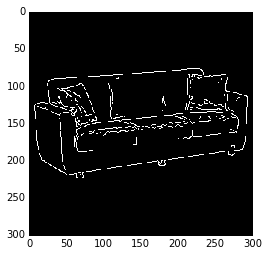

In [67]:
ft_canny = feature.canny(ft_gray, sigma=1)
skimage.io.imshow(ft_canny)

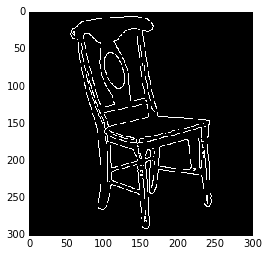

In [68]:
dc_canny = feature.canny(dc_gray, sigma=1)
skimage.io.imshow(dc_canny)

# Get dominant colors

In [80]:
def show_domi_color(image, n_clusters=3):
    nrow, ncol, depth = image.shape 
    lst_of_pixels = [image[irow][icol] for irow in range(nrow) for icol in range(ncol)]
    kmean = KMeans(n_clusters=n_clusters)
    kmean.fit_transform(lst_of_pixels)
    domi_colors = kmean.cluster_centers_ 
    domi_colors = domi_colors.reshape((1,n_clusters,3))
    skimage.io.imshow(domi_colors)
    return domi_colors

array([[[ 0.99545379,  0.99534742,  0.99499355],
        [ 0.260858  ,  0.23378773,  0.2103252 ]]])

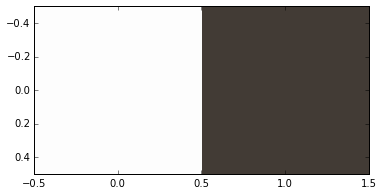

In [90]:
show_domi_color(dc_s,2)

array([[[ 0.41287307,  0.4111672 ,  0.4123232 ],
        [ 0.99697897,  0.99698345,  0.99703543]]])

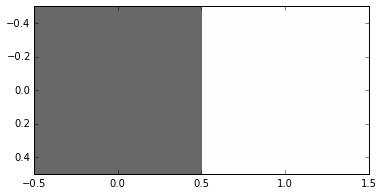

In [91]:
show_domi_color(ft_s,2)

array([[[ 0.99903168,  0.99878974,  0.99828544],
        [ 0.72569777,  0.59101235,  0.40156324]]])

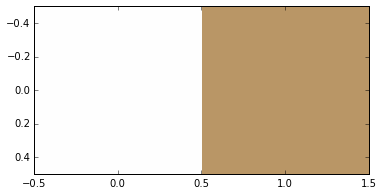

In [92]:
show_domi_color(ns_s,2)

array([[[ 0.32789879,  0.21762493,  0.14094831],
        [ 0.9122282 ,  0.83985693,  0.73882488]]])

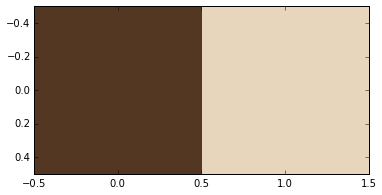

In [89]:
dc2 = skimage.io.imread('image_test/dining_chair/dining_chair_AAM1013_4.jpg')
dc2_s = transform.resize(dc2, (300,300,3))
show_domi_color(dc2_s,2)

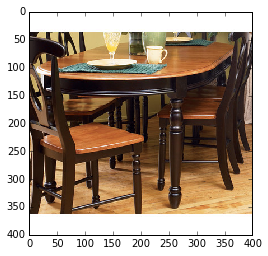

In [86]:
skimage.io.imshow(dc2)

array([[[ 0.91982567,  0.90630636,  0.90144896],
        [ 0.51153655,  0.44642687,  0.3575924 ]]])

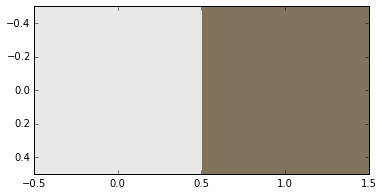

In [88]:
dc3 = skimage.io.imread('image_test/dining_chair/dining_chair_AAM1013_10.jpg')
dc3_s = transform.resize(dc3, (300,300,3))
show_domi_color(dc3_s,2)

array([[[ 0.61830123,  0.56360316,  0.49816156],
        [ 0.99590315,  0.99533759,  0.99440849]]])

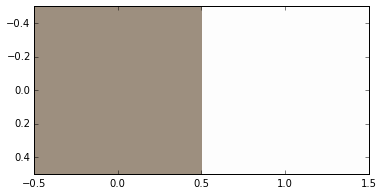

In [93]:
ns2 = skimage.io.imread('image_test/nightstand_ATF1863_0.jpg')
ns2_s = transform.resize(ns2, (300,300,3))
show_domi_color(ns2_s,2)

array([[[ 0.84835724,  0.8357177 ,  0.77182149],
        [ 0.64594748,  0.62315387,  0.40829908]]])

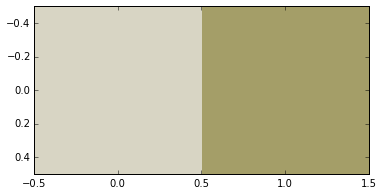

In [99]:
dc4 = skimage.io.imread('image_test/dining_chair/dining_chair_ADEC1338_4.jpg')
dc4_s = transform.resize(dc4, (300,300,3))
show_domi_color(dc4_s,2)

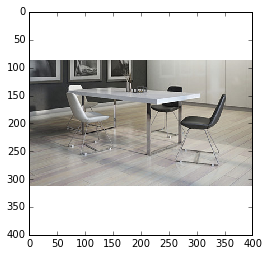

In [110]:
skimage.io.imshow(dt)

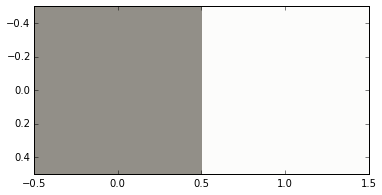

In [114]:
dt = skimage.io.imread('image_test/dining_table/dining_table_AEON1147_1.jpg')
dt_s = transform.resize(dt, (300,300,3))
domi_color = show_domi_color(dt_s,2)

In [117]:
domi_color[0]

array([[ 0.57300862,  0.56091193,  0.5370785 ],
       [ 0.98825312,  0.98839057,  0.98751723]])

# Clustering by dominant colors

### One way to tease out photos with white backgroud: find 2 dominant colors and one of them is white([x,x,x], all x>0.985)

## test sofa images:
* dir
* get dominant color for the furniture
* cluster

In [81]:
sofa_paths = os.listdir('image_test/sofa') 
len(sofa_paths)

112

In [82]:
chair_paths = os.listdir('image_test/dining_chair')
if chair_paths[0] == '.DS_Store':
    chair_paths = chair_paths[1:]
len(chair_paths)

1072

In [595]:
def get_domi_color_for_photo_with_white_background(paths):
    '''
    INPUT:
        paths: list, paths of image files
    For all files in paths, 
        tease out photos without a clear white background and save those into 'background' folder.
    For those with white background, save then to 'white' folder.
    OUTPUT:
        domi_color_dict: dictionary, key=path and value=dominant color(just one).
    '''
    domi_color_dict = {}
    
    for path in paths:
        category = '_'.join(path.split('_')[0:-2])
        image = skimage.io.imread('image_test/' + category + '/' + path)
        
        # If the picture is grayscale, discard it for now. Think about how to improve it later.
        
        if len(image.shape) == 2:
            print 'gray'
            continue
            
        image = transform.resize(image, (300,300,3))

        nrow, ncol, depth = image.shape 
        lst_of_pixels = [image[irow][icol] for irow in range(nrow) for icol in range(ncol)]

        """Remove photos without clean white background:
            If one of the two dominant color is white, 
            when the photo has a clean white background and flag=True."""

        kmean1 = KMeans(n_clusters=2)
        kmean1.fit_transform(lst_of_pixels)
        domi_colors_all = kmean1.cluster_centers_ 
        white_color_arr = np.array([0.98, 0.98, 0.98])
        

        flag = False
        for color in domi_colors_all:
            if np.mean(color>white_color_arr) == 1:
                flag = True
            else:
                domi_color = color

        if not flag:    
            new_path = 'image_test_result/background/' + path
            skimage.io.imsave(new_path, image)
            continue
        else:
            new_path = 'image_test_result/white/' + path
            skimage.io.imsave(new_path, image)
            domi_color_dict[path] = domi_color 
        
    return domi_color_dict


9:45

In [596]:
domi_color_dict = get_domi_color_for_photo_with_white_background(chair_paths)

9:52

In [89]:
len(domi_color_dict.keys())

680

In [199]:
def clustering_with_domi_color(domi_color_dict, category, n_clusters=6):
    '''
    INPUT: domi_color_dict:
            * key: path
            * value: dominant color (just one)
    
    Cluster by color & save files to different folders according to labels.
    
    OUTPUT: cluster_label_dict
            * key: path
            * value: cluster label
            color_centroids:
            * index: label 
            * value: centroid
    '''
    domi_color_values = domi_color_dict.values()
    
    domi_color_reverse_dict = {}
    for i, j in domi_color_dict.iteritems():
        domi_color_reverse_dict[tuple(j)] = i 
        
    km_color = KMeans(n_clusters=n_clusters)
    domi_colors_labels =km_color.fit_predict(domi_color_values)
    
    color_centroids = km_color.cluster_centers_
             
    cluster_label_dict = {}
    for i, j in enumerate(domi_color_values):
        label = domi_colors_labels[i]
        path = domi_color_reverse_dict[tuple(j)]
        cluster_label_dict[path] = label
        
        image = skimage.io.imread('image_test/' + category + '/' + path)
        new_path = 'image_test_result/' + str(label) + '/' + path
        skimage.io.imsave(new_path, image)
    
    return cluster_label_dict, color_centroids

In [95]:
cluster_label_dict, color_centroids = clustering_with_domi_color(domi_color_dict, 'dining_chair', n_clusters=12)

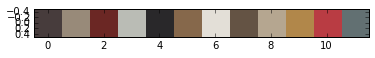

In [96]:
color_centroids = color_centroids.reshape((1,12,3))
skimage.io.imshow(color_centroids)

# Clustering by features:

In [670]:
image_pipe = ImagePipeline('image_test_result/')
image_pipe.read(sub_dirs=('white',))

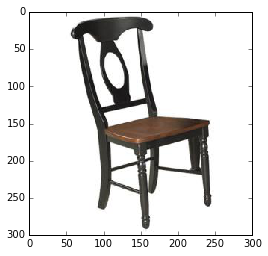

In [671]:
image_pipe.show('white', 0)

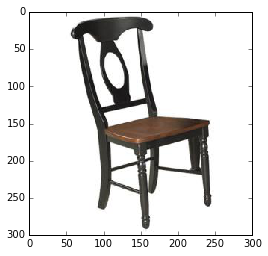

In [672]:
skimage.io.imshow(image_pipe.img_lst2[0][0])

In [673]:
image_pipe.resize((150,150,3))
image_pipe.transform(skimage.color.rgb2gray, {})
image_pipe.vectorize()
features = image_pipe.features

In [674]:
features.shape

(679, 22500)

In [675]:
chair_paths = os.listdir('image_test_result/white')
if chair_paths[0] == '.DS_Store':
    chair_paths = chair_paths[1:]
len(chair_paths)

679

In [676]:
feature_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features[i]
    feature_dict[path] = feature

In [6]:
def clustering_with_feature(feature_dict, n_clusters=6, svd=False, save_image=True, edge=False):
    '''
    INPUT: feature_dict:
            * key: path
            * value: feature
    
    Cluster by feature & save files to different folders according to labels.
    
    OUTPUT: cluster_label_dict
            * key: path
            * value: cluster label
            feature_centroids:
            * index: label 
            * value: centroid
    '''
    feature_values = feature_dict.values()
    
    feature_reverse_dict = {}
    for i, j in feature_dict.iteritems():
        feature_reverse_dict[tuple(j)] = i 
        
    km_feature = KMeans(n_clusters=n_clusters)
    feature_labels = km_feature.fit_predict(feature_values)
    
    feature_centroids = km_feature.cluster_centers_
             
    cluster_label_dict = {}
    for i, j in enumerate(feature_values):
        label = feature_labels[i]
        path = feature_reverse_dict[tuple(j)]
        cluster_label_dict[path] = label
        
        if save_image:
            image = skimage.io.imread('image_test_result/same_angle/' + path)
            if svd:
                new_path = 'image_test_result/features_svd/' + str(label) + '/' + path
            elif edge:
                new_path = 'image_test_result/features_edge/' + str(label) + '/' + path
            else:
                new_path = 'image_test_result/features/' + str(label) + '/' + path
            skimage.io.imsave(new_path, image)
    
    return cluster_label_dict, feature_centroids

In [680]:
cluster_label_dict, feature_centroids = clustering_with_feature(feature_dict, n_clusters=10)

In [681]:
Counter(cluster_label_dict.values())

Counter({0: 90, 1: 239, 2: 9, 3: 19, 4: 45, 5: 99, 6: 34, 7: 59, 8: 26, 9: 59})

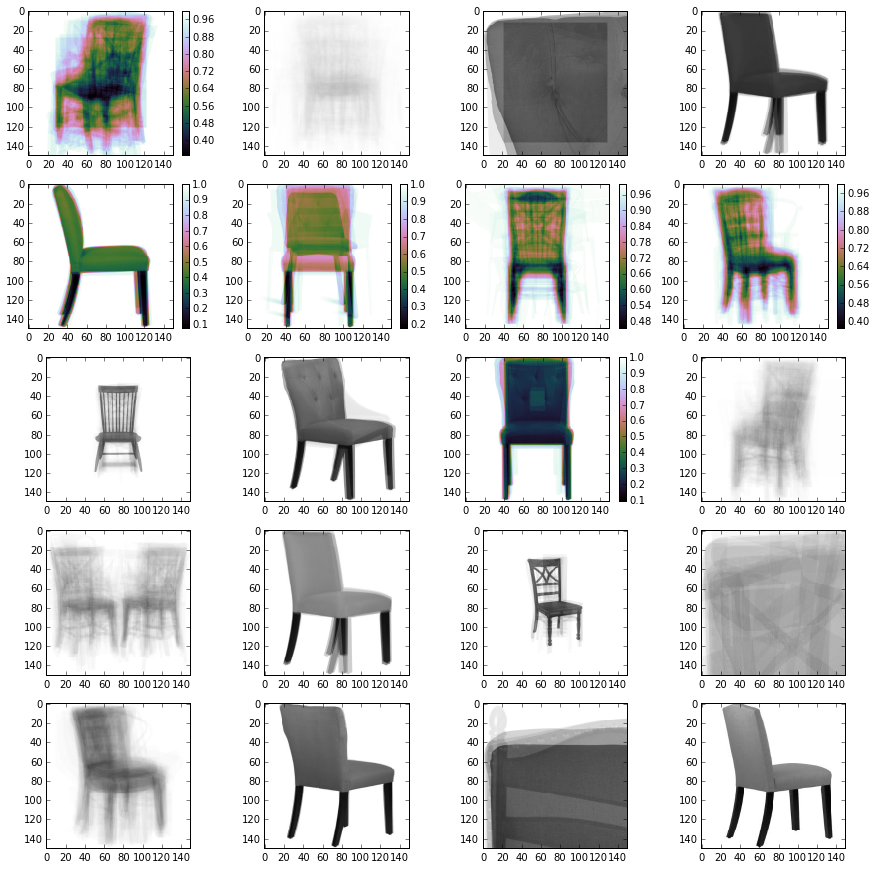

In [234]:
plt.figure(figsize = (15,15))
for i in range(20):
    plt.subplot(5,4,i+1)
    skimage.io.imshow(feature_centroids[i].reshape(150,150))

# SVD!

In [128]:
features.shape

(680, 22500)

In [131]:
print time.ctime(time.time())
U, sigma, VT = svd(features)
print time.ctime(time.time())

'Thu Sep 24 22:53:07 2015'

In [132]:
U.shape, sigma.shape, VT.shape

((680, 680), (680,), (22500, 22500))

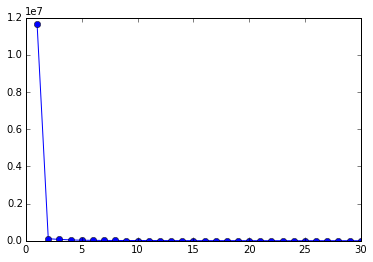

In [135]:
plt.plot(range(1,31),sigma[:30]**2, '-o')

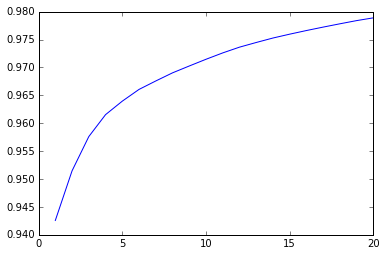

In [139]:
k = 20
plt.plot(range(1, k+1), np.cumsum(sigma[:k]**2) / np.sum(sigma**2))

# Reduce feature dimension to 20:

In [143]:
features_reduced = U[:,:20]
features_reduced.shape

(680, 20)

In [144]:
feature_reduced_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features_reduced[i]
    feature_reduced_dict[path] = feature

# Cluster by dimension-reduced features

In [235]:
cluster_label_dict_reduced, feature_reduced_centroids = clustering_with_feature(feature_reduced_dict, 
                                                                                n_clusters=20, svd=True, save_image=False)

# Display average image for each label:

In [236]:
label_dict = defaultdict(list)
for i,j in cluster_label_dict_reduced.iteritems():
    label_dict[j].append(i)

In [238]:
label_image_avg = {}
for i in label_dict:
    for j, path in enumerate(label_dict[i]):
        image = skimage.io.imread('image_test_result/white/' + path)
        image = transform.resize(image, (300,300,3))
        if j == 0:
            sum_image = image
            length = 1
        else:
            sum_image = sum_image + image
            length += 1
    label_image_avg[i] = sum_image/length

In [239]:
len(label_image_avg)

20

In [240]:
label_image_avg[0].shape

(300, 300, 3)

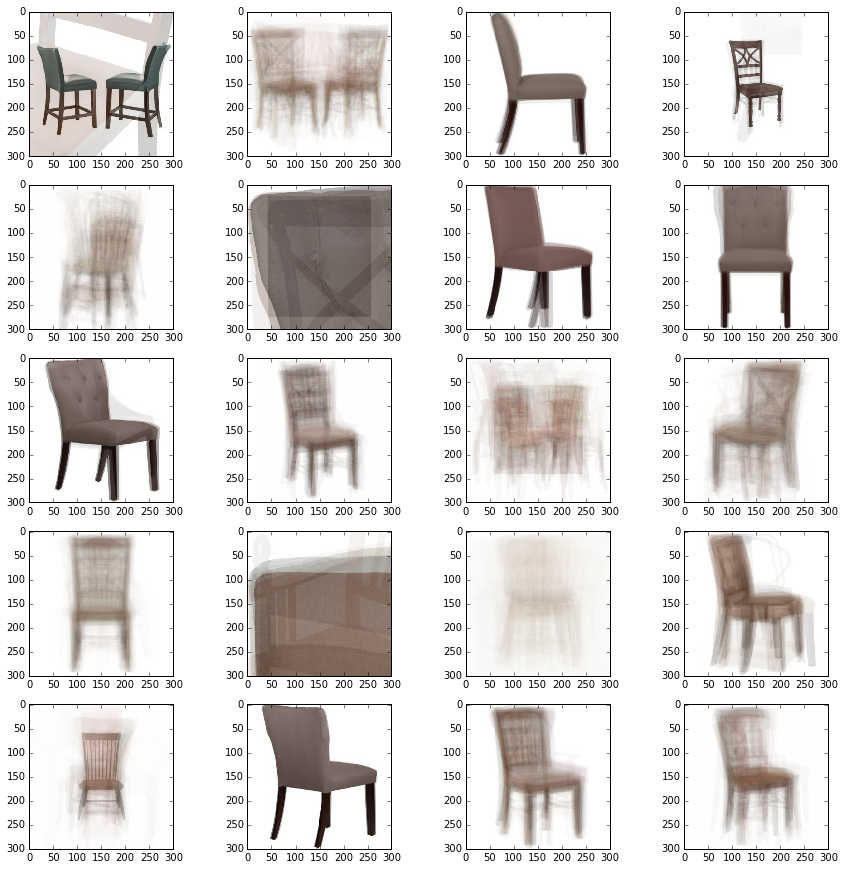

In [241]:
plt.figure(figsize = (15,15))
for i in range(20):
    plt.subplot(5,4,i+1)
    skimage.io.imshow(label_image_avg[i])

In [242]:
Counter(cluster_label_dict_reduced.values())

Counter({0: 4,
         1: 36,
         2: 34,
         3: 14,
         4: 39,
         5: 16,
         6: 29,
         7: 36,
         8: 16,
         9: 23,
         10: 31,
         11: 41,
         12: 59,
         13: 16,
         14: 145,
         15: 20,
         16: 46,
         17: 14,
         18: 28,
         19: 33})

# Thoughs for color: instead of one dominant color, get a color distribution vector with binned frequency of ranges of R, G, B respectively. Get rid of perfectly white points ahead of time.

In [243]:
color_centroids

array([[[ 0.278679  ,  0.23814766,  0.23585203],
        [ 0.59842016,  0.54213813,  0.4758983 ],
        [ 0.4223179 ,  0.15681925,  0.14352783],
        [ 0.73172618,  0.7386802 ,  0.71253401],
        [ 0.16280493,  0.15891385,  0.16734576],
        [ 0.5274559 ,  0.41170267,  0.29666748],
        [ 0.89033051,  0.87836326,  0.84640622],
        [ 0.39477129,  0.32819736,  0.26720684],
        [ 0.71351227,  0.65162335,  0.56738345],
        [ 0.69518263,  0.53318624,  0.29092351],
        [ 0.72588293,  0.23570623,  0.264775  ],
        [ 0.38769169,  0.44236639,  0.44815196]]])

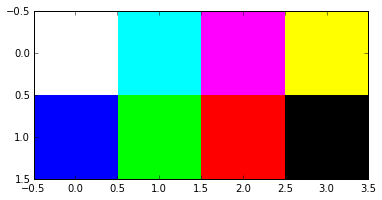

In [291]:
skimage.io.imshow(np.array([[[1., 1., 1.], [0., 1.,1.],  [1., 0.,1.],  [1., 1.,0.]],
                           [[0., 0., 1.], [0., 1,0.],  [1., 0.,0.],  [0., 0.,0.]]]))

In [287]:
a = np.array([[[255, 255, 255], [0, 255, 255],  [255, 0, 255],  [255, 255, 0]],
             [[0, 0, 255], [0, 255, 0],  [255, 0, 0],  [0, 0, 0]]])
a = np.uint8(a)

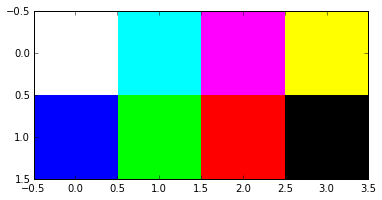

In [288]:
skimage.io.imshow(a)

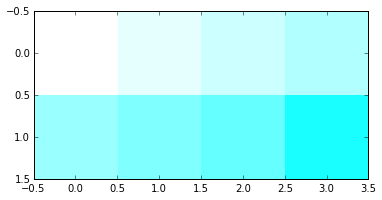

In [289]:
skimage.io.imshow(np.array([[[1., 1., 1.], [0.9, 1.,1.],  [0.8, 1.,1.],  [0.7, 1.,1.]],
                           [[0.6, 1.,1.], [0.5, 1.,1.],  [0.4, 1.,1.],  [0.1, 1.,1.]]]))

# Standard scaler in sklearn for grayscaled images doesn't work well:

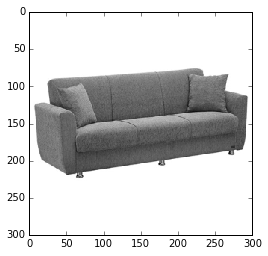

In [328]:
skimage.io.imshow(ft_gray)

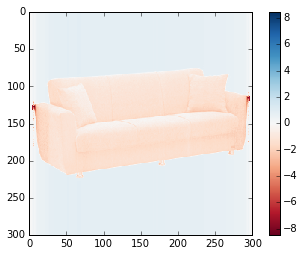

In [327]:
skimage.io.imshow(StandardScaler().fit_transform(ft_gray))

In [322]:
np.std(dc_gray)

0.30040191408138872

In [326]:
np.min(StandardScaler(with_mean=True, with_std=True).fit_transform(dc_gray))

-10.685459923352798

# Color distribution:

In [382]:
def plot_color_distribution_with_white(image):
    nrow, ncol, depth = image.shape 
    lst_of_pixels = np.array([image[irow][icol] for irow in range(nrow) for icol in range(ncol)])
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    skimage.io.imshow(image)
    plt.subplot(1,2,2)
    plt.hist(lst_of_pixels[:,0], bins=50, color='r', alpha=0.3)
    plt.hist(lst_of_pixels[:,1], bins=50, color='g', alpha=0.3)
    plt.hist(lst_of_pixels[:,2], bins=50, color='b', alpha=0.3)

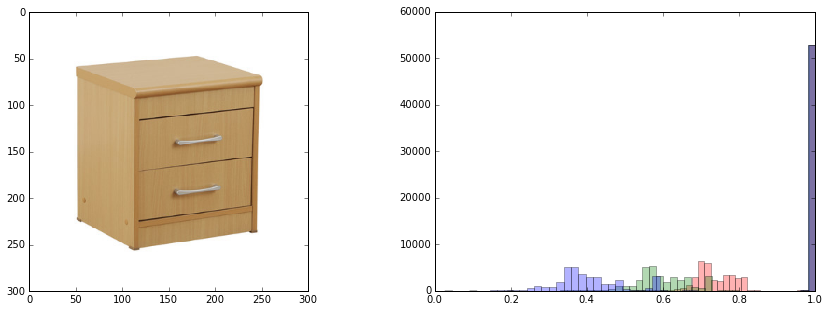

In [383]:
plot_color_distribution_with_white(ns_s)

In [527]:
def plot_color_distribution(image, bins=50):
     
    image = transform.resize(image, (300,300,3))
    nrow, ncol, depth = image.shape
    
    white_pixel = np.array([ .99, .99, .99])
    lst_of_pixels = np.array([image[irow][icol] for irow in range(nrow) for icol in range(ncol) if np.mean(image[irow][icol]>white_pixel) != 1])
    
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    skimage.io.imshow(image)
    plt.subplot(1,2,2)
    plt.hist(lst_of_pixels[:,0], bins=bins, color='r', alpha=0.3)
    plt.hist(lst_of_pixels[:,1], bins=bins, color='g', alpha=0.3)
    plt.hist(lst_of_pixels[:,2], bins=bins, color='b', alpha=0.3)

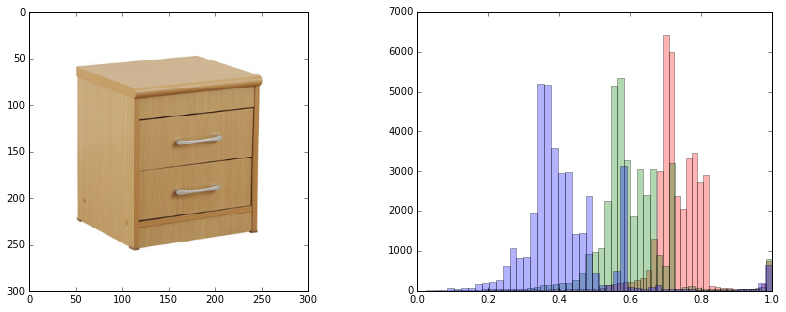

In [385]:
plot_color_distribution(ns_s)

In [386]:
sf_r = skimage.io.imread('image_test/sofa/sofa_BL3429_19.jpg')

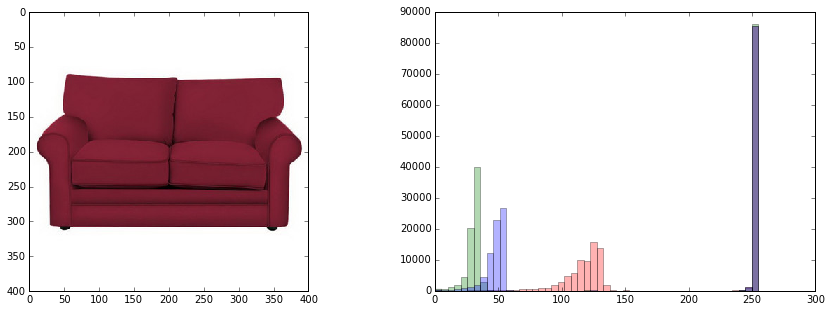

In [387]:
plot_color_distribution_with_white(sf_r)

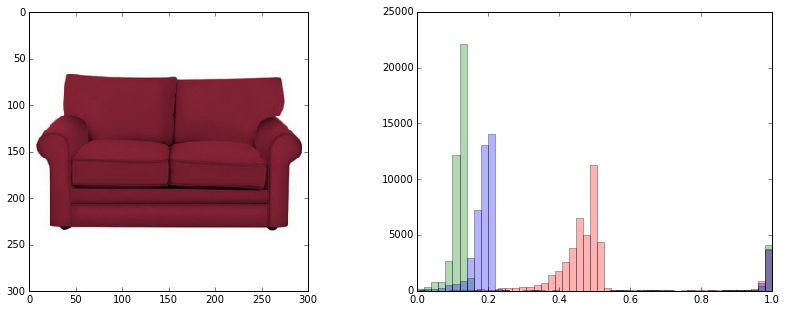

In [388]:
sf_r_s = transform.resize(sf_r, (300,300,3))
plot_color_distribution(sf_r_s)

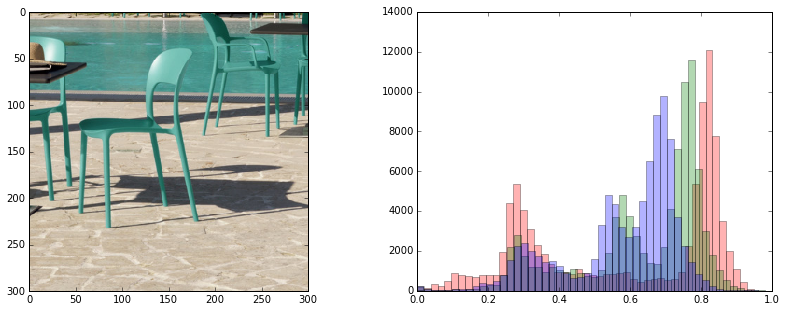

In [400]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_BTC1291_15.jpg')
dc_b_s = transform.resize(dc_b, (300,300,3))

plot_color_distribution(dc_b_s)

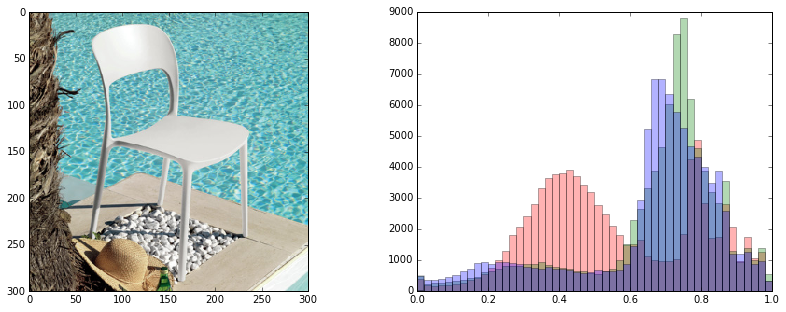

In [435]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_BTC1291_14.jpg')
dc_b_s = transform.resize(dc_b, (300,300,3))

plot_color_distribution(dc_b_s)
plt.show()

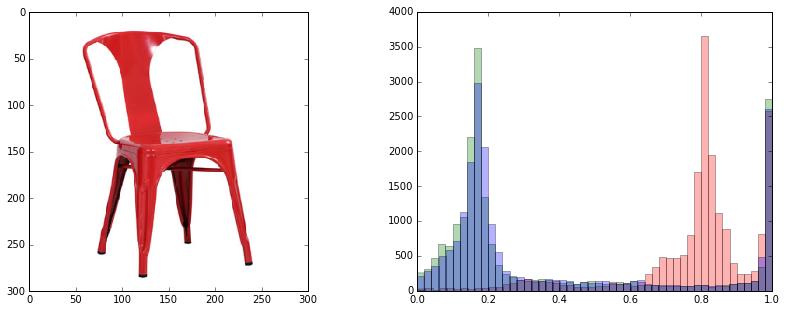

In [402]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_BUF1659_1.jpg')
dc_b_s = transform.resize(dc_b, (300,300,3))

plot_color_distribution(dc_b_s)

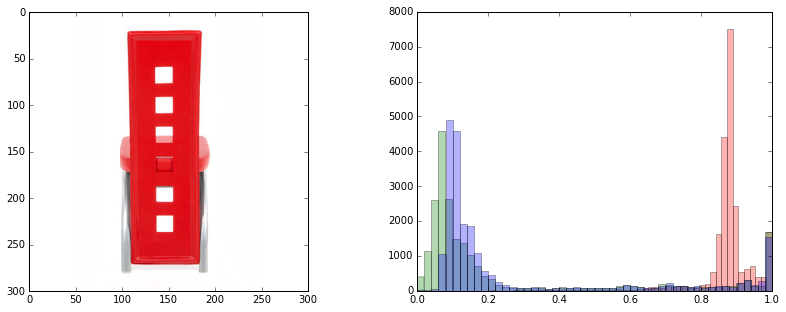

In [656]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_CST7944_3.jpg')
dc_b_s = transform.resize(dc_b, (300,300,3))

plot_color_distribution(dc_b_s)

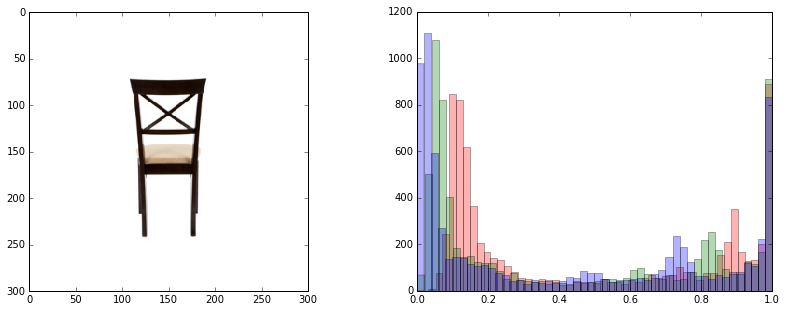

In [657]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_CST1945_8.jpg')
dc_b_s = transform.resize(dc_b, (300,300,3))

plot_color_distribution(dc_b_s)

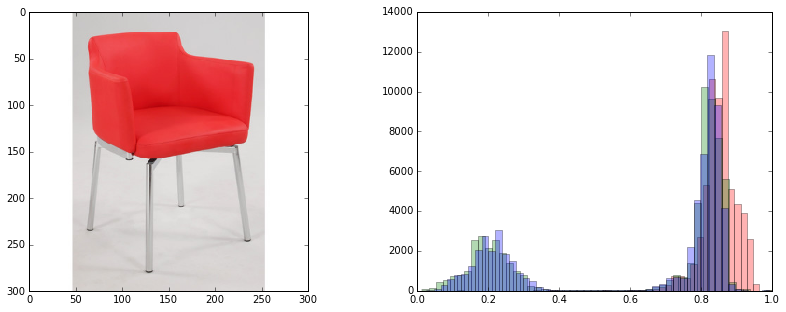

In [403]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_CNI3124_1.jpg')
dc_b_s = transform.resize(dc_b, (300,300,3))

plot_color_distribution(dc_b_s)

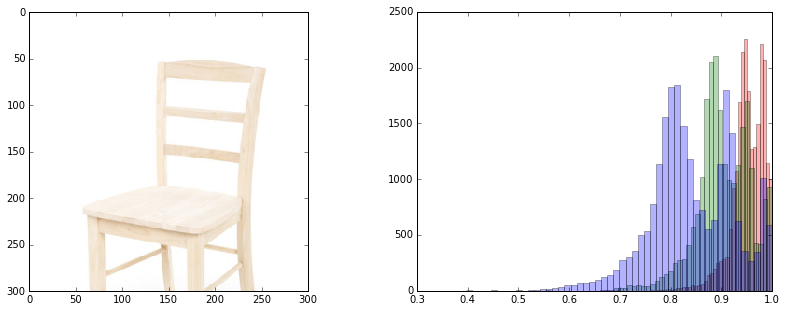

In [441]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_ATGR1106_17.jpg')
dc_b_s_1 = transform.resize(dc_b, (300,300,3))

plot_color_distribution(dc_b_s_1)

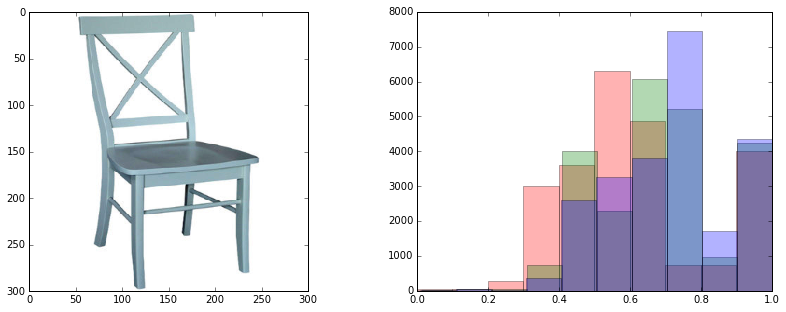

In [508]:
plot_color_distribution(skimage.exposure.rescale_intensity(dc_b_s), bins=10)

In [522]:
dc_b = skimage.io.imread('image_test/dining_chair/dining_chair_ATGR1030_2.jpg')
dc_b_s = transform.resize(dc_b, (300,300,3))

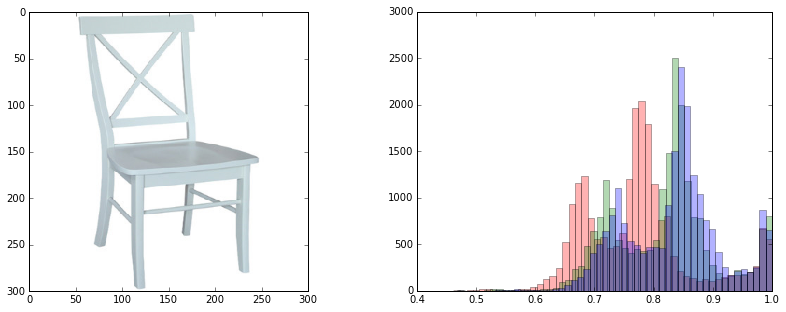

In [528]:
plot_color_distribution(dc_b_s, bins=50)

# Vectorize color distribution!

In [650]:
def vectorize_color_distribution(paths):
    
    '''INPUT:
            paths: list of strings
                file paths
       OUTPUT:
            color_dist_dict: dictionary 
                key: path 
                value: vectorized color distribution (a 1D numpy array of 30 numbers representing RBG 
                                                        intensities, 10 numbers for each color)
    '''
    
    color_dist_dict = {}
    
    for path in paths:
        #category = '_'.join(path.split('_')[0:-2])
        
        image = skimage.io.imread('image_test_result/' + 'white' + '/' + path)
        image = transform.resize(image, (300,300,3))
    
        nrow, ncol, depth = image.shape 
        white_pixel = np.array([ .99, .99, .99])
        lst_of_pixels = np.array([image[irow][icol] for irow in range(nrow) for icol in range(ncol) if np.mean(image[irow][icol]>white_pixel) != 1])

        red_values = lst_of_pixels[:,0]
        green_values = lst_of_pixels[:,1]
        blue_values = lst_of_pixels[:,2]

        (n_red, bins) = np.histogram(red_values, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
        (n_green, bins) = np.histogram(green_values, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
        (n_blue, bins) = np.histogram(blue_values, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
        
        num_of_pixels = float(len(lst_of_pixels))
        n_red = n_red / num_of_pixels
        n_green = n_green / num_of_pixels
        n_blue = n_blue / num_of_pixels

        color_dist_vector = np.hstack((n_red, n_green, n_blue))
        color_dist_dict[path] = color_dist_vector
        
    return color_dist_dict

In [651]:
white_paths = os.listdir('image_test_result/white') 

8:27

In [652]:
color_dist_dict = vectorize_color_distribution(white_paths)

< 8:42

# Cluster with color distrubution vector:

In [661]:
def clustering_with_color_dist(color_dist_dict, category, n_clusters=6):
    '''
    INPUT: color_dist_dict:
            * key: path
            * value: color distribution vector
    
    Cluster by color & save files to different folders according to labels.
    
    OUTPUT: cluster_label_dict
            * key: path
            * value: cluster label
            color_dist_centroids:
            * index: label 
            * value: centroid
    '''
    color_dist_values = color_dist_dict.values()
    
    color_dist_reverse_dict = {}
    for i, j in color_dist_dict.iteritems():
        color_dist_reverse_dict[tuple(j)] = i 
        
    km_color = KMeans(n_clusters=n_clusters)
    color_dist_labels =km_color.fit_predict(color_dist_values)
    
    color_dist_centroids = km_color.cluster_centers_
             
    cluster_label_dict = {}
    for i, j in enumerate(color_dist_values):
        label = color_dist_labels[i]
        path = color_dist_reverse_dict[tuple(j)]
        cluster_label_dict[path] = label
        
        image = skimage.io.imread('image_test/' + category + '/' + path)
        new_path = 'image_test_result/color_dist/' + str(label) + '/' + path
        skimage.io.imsave(new_path, image)
    
    return cluster_label_dict, color_centroids

In [662]:
cluster_label_dict, color_centroids = clustering_with_color_dist(color_dist_dict, 'dining_chair', n_clusters=20)

# The color_distribution clustering result is worse than dominant_color clustering....@__@

# Clustering with edged_features:

In [22]:
image_pipe = ImagePipeline('image_test_result/')
image_pipe.read(sub_dirs=('white',))

image_pipe.resize((150,150,3))
image_pipe.transform(skimage.color.rgb2gray, {})
image_pipe.transform(skimage.feature.canny, {})

image_pipe.vectorize()
features_edged = image_pipe.features
print features_edged.shape

chair_paths = os.listdir('image_test_result/white')
if chair_paths[0] == '.DS_Store':
    chair_paths = chair_paths[1:]
print len(chair_paths)

feature_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features_edged[i]
    feature_dict[path] = feature

cluster_label_dict_edged, feature_edged_centroids = clustering_with_feature(feature_dict, 
                                                                                n_clusters=10, edge=True, save_image=False)

(679, 22500)
679


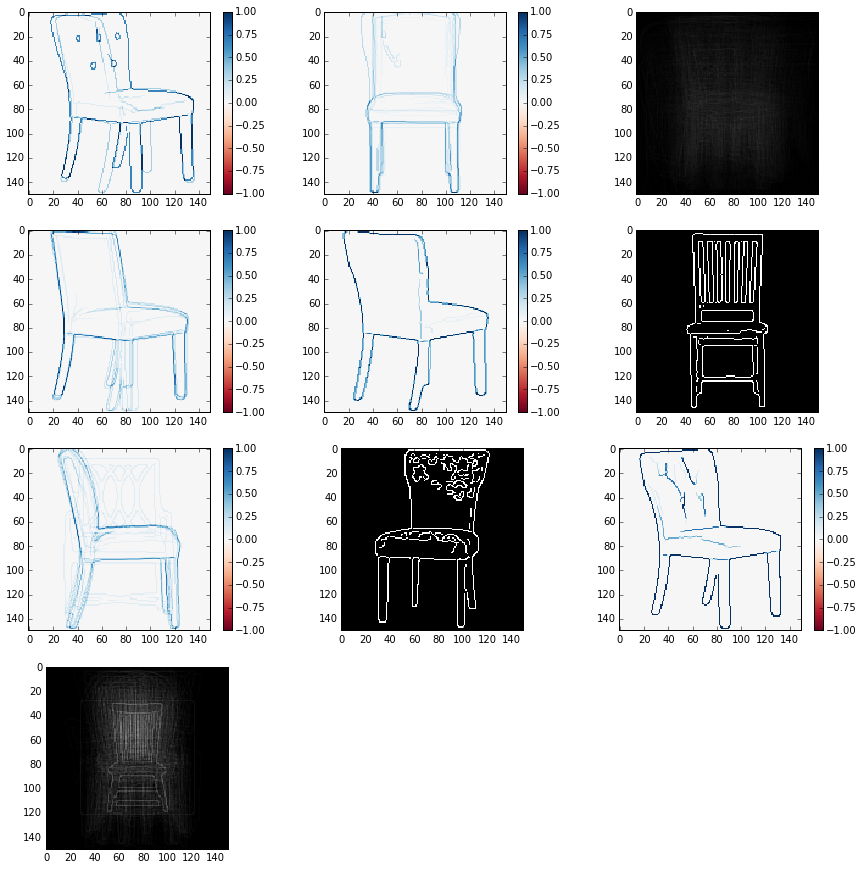

In [23]:
plt.figure(figsize = (15,15))
for i in range(10):
    plt.subplot(4,3,i+1)
    skimage.io.imshow(feature_edged_centroids[i].reshape(150,150))

# Now Working with same angled chair photos:

# Clustering with features - same angled chair photos:

In [7]:
image_pipe = ImagePipeline('image_test_result/')
image_pipe.read(sub_dirs=('same_angle',))

image_pipe.resize((150,150,3))
image_pipe.transform(skimage.color.rgb2gray, {})
#image_pipe.transform(skimage.feature.canny, {})

image_pipe.vectorize()
features = image_pipe.features
print features.shape

chair_paths = os.listdir('image_test_result/same_angle')
if chair_paths[0] == '.DS_Store':
    chair_paths = chair_paths[1:]
print len(chair_paths)

feature_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features[i]
    feature_dict[path] = feature

cluster_label_dict, feature_centroids = clustering_with_feature(feature_dict, 
                                                                n_clusters=10, save_image=True)

(209, 22500)
209


//anaconda/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warnings.warn("Float image out of standard range; displaying "


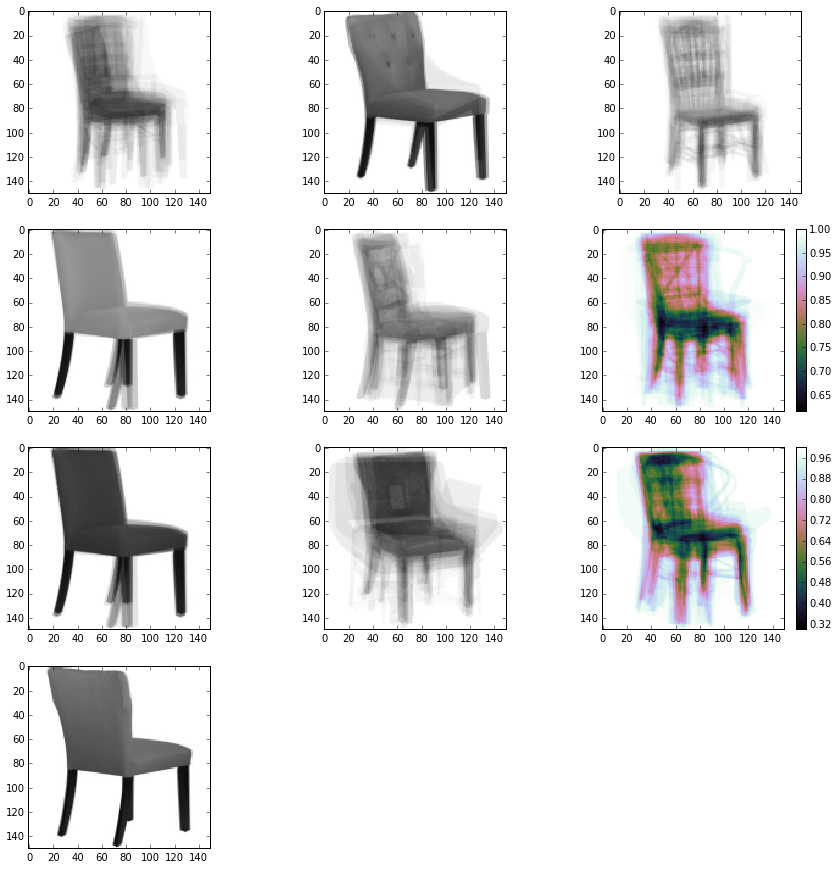

In [8]:
plt.figure(figsize = (15,15))
for i in range(10):
    plt.subplot(4,3,i+1)
    skimage.io.imshow(feature_centroids[i].reshape(150,150))

# Clustering with edged_features - same angled chair photos:

In [10]:
image_pipe = ImagePipeline('image_test_result/')
image_pipe.read(sub_dirs=('same_angle',))

image_pipe.resize((150,150,3))
image_pipe.transform(skimage.color.rgb2gray, {})
image_pipe.transform(skimage.feature.canny, {})

image_pipe.vectorize()
features_edged = image_pipe.features
print features_edged.shape

chair_paths = os.listdir('image_test_result/same_angle')
if chair_paths[0] == '.DS_Store':
    chair_paths = chair_paths[1:]
print len(chair_paths)

feature_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features_edged[i]
    feature_dict[path] = feature

cluster_label_dict_edged, feature_edged_centroids = clustering_with_feature(feature_dict, 
                                                                                n_clusters=10, edge=True, save_image=True)

(209, 22500)
209


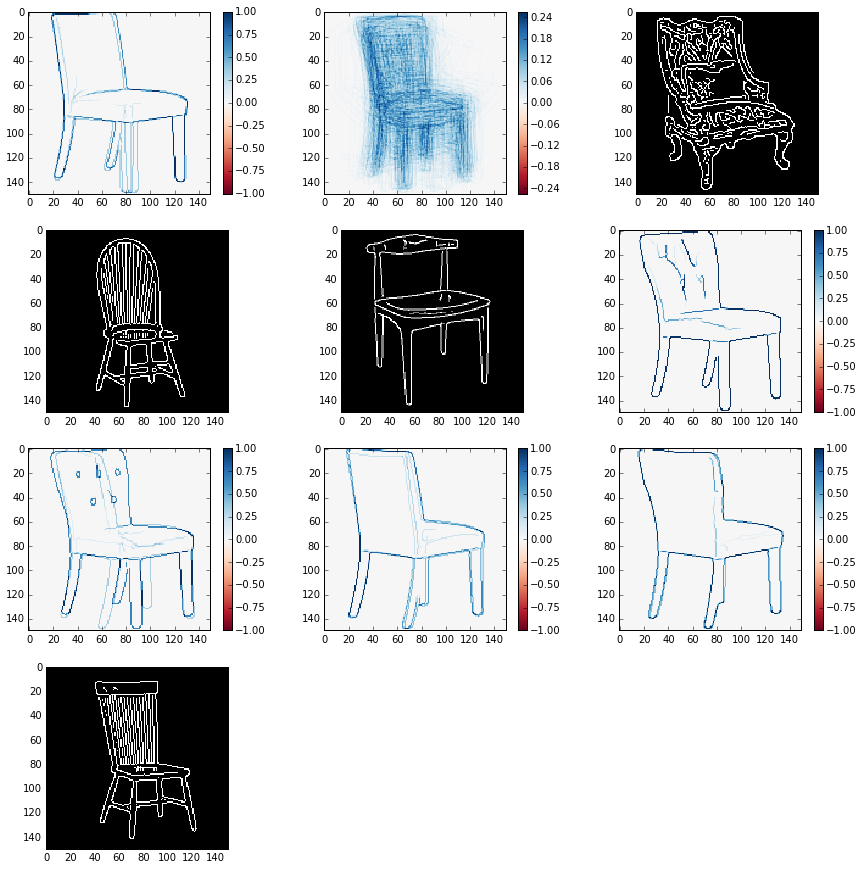

In [11]:
plt.figure(figsize = (15,15))
for i in range(10):
    plt.subplot(4,3,i+1)
    skimage.io.imshow(feature_edged_centroids[i].reshape(150,150))

# Clustering with SVD & edged features - same angled chair photos:

In [12]:
print time.ctime(time.time())
U, sigma, VT = svd(features_edged)
print time.ctime(time.time())

Sun Sep 27 16:32:12 2015
Sun Sep 27 16:35:01 2015


In [17]:
sigma.shape

(209,)

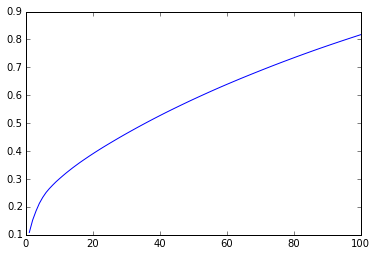

In [21]:
k = 100
plt.plot(range(1, k+1), np.cumsum(sigma[:k]**2) / np.sum(sigma**2))

In [22]:
features_reduced = U[:,:100]

feature_reduced_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features_reduced[i]
    feature_reduced_dict[path] = feature

In [23]:
cluster_label_dict_reduced, feature_reduced_centroids = clustering_with_feature(feature_reduced_dict, 
                                                                                n_clusters=10, svd=True, save_image=True)

# Clustering with SVD features - same angled chair photos:

In [24]:
print time.ctime(time.time())
U, sigma, VT = svd(features)
print time.ctime(time.time())

Sun Sep 27 16:40:39 2015
Sun Sep 27 16:45:19 2015


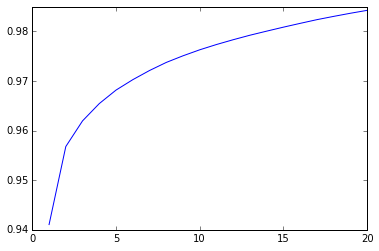

In [31]:
k = 20
plt.plot(range(1, k+1), np.cumsum(sigma[:k]**2) / np.sum(sigma**2))

In [25]:
len(chair_paths)

209

In [32]:
features_reduced = U[:,:20]
features_reduced.shape

(209, 20)

In [33]:
feature_reduced_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features_reduced[i]
    feature_reduced_dict[path] = feature

cluster_label_dict_reduced, feature_reduced_centroids = clustering_with_feature(feature_reduced_dict, 
                                                                                n_clusters=10, svd=True, save_image=True)

# Try rescaling exposure!

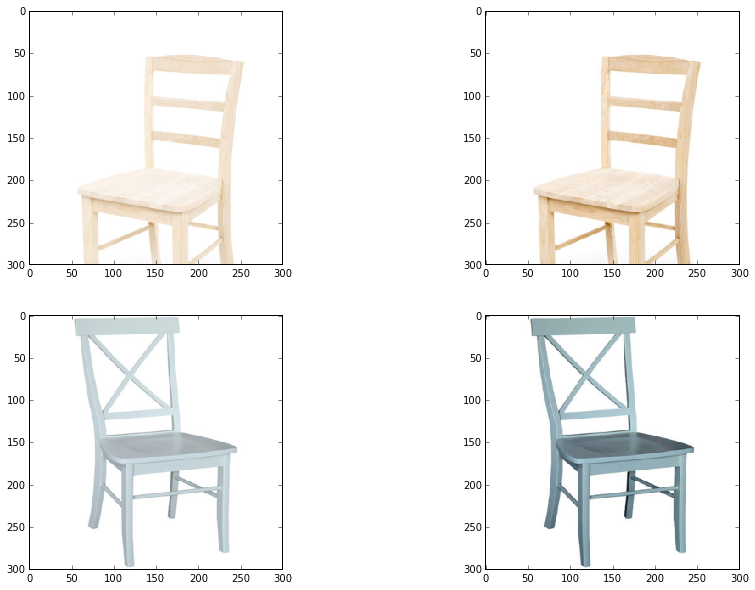

In [447]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
skimage.io.imshow(dc_b_s_1)
plt.subplot(2,2,2)
skimage.io.imshow(skimage.exposure.rescale_intensity(dc_b_s_1))
plt.subplot(2,2,3)
skimage.io.imshow(dc_b_s)
plt.subplot(2,2,4)
skimage.io.imshow(skimage.exposure.rescale_intensity(dc_b_s))

# Summary so far:

* dominant color: works
* color distribution: doesn't work as well as dominant color. May work better with furnitures with more complicated color patterns.


### with all chair photos:
general features, edge, svd all seems to work well (to pick up big differences)

### With chair of the same angle (smaller differences):
* edge non-svd: 
    doesn't work well
* general feature non_svd: 
    just so so, may pick up more gray-scale difference than shape difference
* edge svd: 
    doesn't work well
* general feature svd 100:
    no good
* general feature svd 20:
    so so